## Intro 


This notebook explores greenhouse gas emmisions across the UK, using the geopandas library. 

**Important terminology:**

kt_co2e = Kiloton Carbon Dioxide Equivalent. Each greenhouse gas has been given a kt_co2e value, which allows us to compare them to eachother.   
CO2 = Carbon Dioxide  
CH4 = Methane   
N2O = Nitrous Oxide 

## Imports 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', None)

## Explore emissions data 

In [2]:
df = pd.read_csv('data/uk-local-authority-ghg-emissions-2020-dataset.csv')
df.columns = [x.lower().replace(' ', '_').replace('-', '_').strip() for x in df.columns]

In [3]:
df.head(2)

,country,country_code,region,region_code,second_tier_authority,local_authority,local_authority_code,calendar_year,la_ghg_sector,la_ghg_sub_sector,greenhouse_gas,territorial_emissions_(kt_co2e),co2_emissions_within_the_scope_of_influence_of_las_(kt_co2e),mid_year_population_(thousands),area_(km2)
0,England,E92000001,East Midlands,E12000004,Derby,Derby,E06000015,2005,Agriculture,Agriculture Electricity,CH4,0.011,0.000,236.470,78.031
1,England,E92000001,East Midlands,E12000004,Derby,Derby,E06000015,2005,Agriculture,Agriculture Electricity,CO2,0.380,0.380,236.470,78.031


In [4]:
# data from 2005 to 2020 
df.calendar_year.min(), df.calendar_year.max()

(2005, 2020)

In [5]:
df.country.nunique(), df.local_authority.nunique()

(5, 377)

In [6]:
df.country.unique()

array(['England', 'Northern Ireland', 'Scotland', 'Unallocated', 'Wales'],
      dtype=object)

In [7]:
#CH4 = methane, N20 = Nitrous Oxide 
df.greenhouse_gas.unique()

array(['CH4', 'CO2', 'N2O'], dtype=object)

In [8]:
data_co2 = df[df.greenhouse_gas == 'CO2']\
    .groupby('la_ghg_sector')['territorial_emissions_(kt_co2e)'].sum()\
    .sort_values(ascending = True)

data_ch4 = df[df.greenhouse_gas == 'CH4']\
    .groupby('la_ghg_sector')['territorial_emissions_(kt_co2e)'].sum()\
    .sort_values(ascending = True)

data_n2o = df[df.greenhouse_gas == 'N2O']\
    .groupby('la_ghg_sector')['territorial_emissions_(kt_co2e)'].sum()\
    .sort_values(ascending = True)

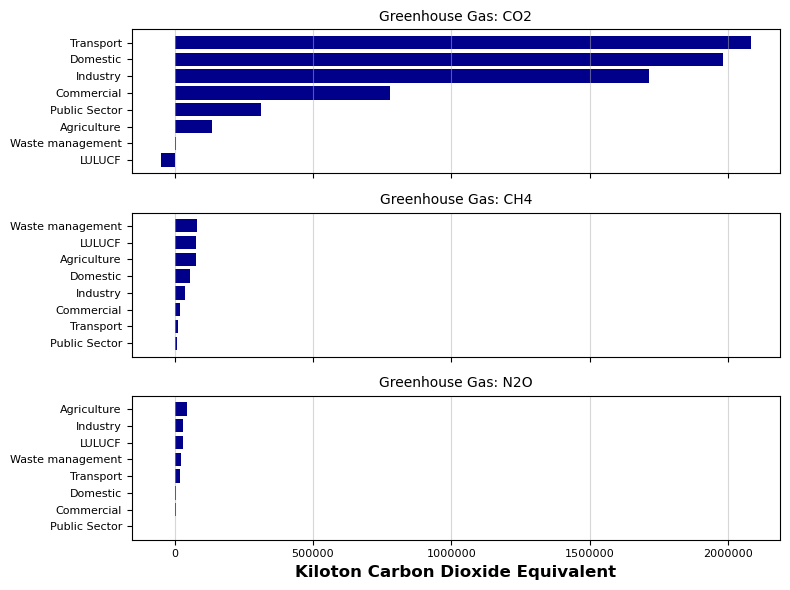

In [9]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6), sharex = True)

for i, data in enumerate(zip([data_co2, data_ch4, data_n2o], ['CO2', 'CH4', 'N2O'])): 
    ax[i].barh(data[0].index, data[0], color = 'darkblue')
    ax[i].set_title('Greenhouse Gas: {gas}'.format(gas = data[1]), fontsize = 10)
    ax[i].grid(True, axis = 'x', alpha = 0.5)
    ax[i].tick_params(labelsize = 8)
    

plt.xlabel('Kiloton Carbon Dioxide Equivalent', fontweight = 'bold', fontsize = 12)  

# removing scientific notation 
ax[2].ticklabel_format(style='plain', axis = 'x')
fig.tight_layout()

# LULUCF = Land Use, Land-use Change and Forestry covers the following categories; 
# Forest land, Cropland, Grassland, Wetlands, Settlements, Other land and Harvested Wood products. 

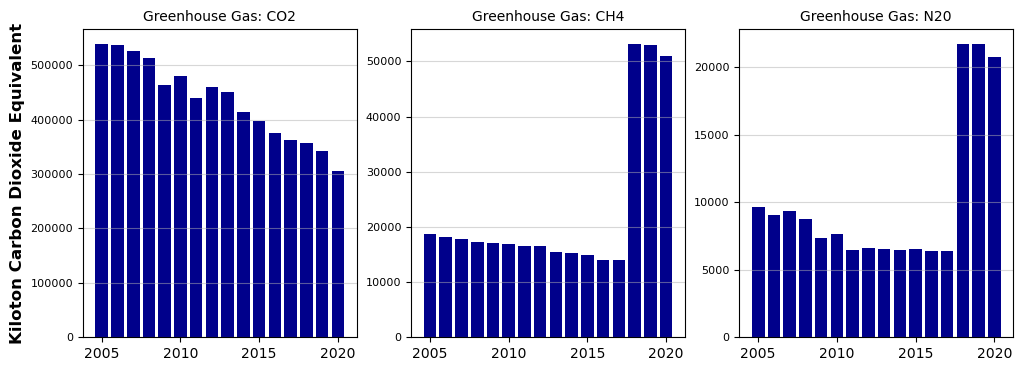

In [10]:
# let's look at different greenhouse gas emmisions across the years 
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

co2_ts = df[(df.greenhouse_gas == 'CO2')]\
    .groupby('calendar_year')['territorial_emissions_(kt_co2e)'].sum().sort_index()

ch4_ts = df[(df.greenhouse_gas == 'CH4')]\
    .groupby('calendar_year')['territorial_emissions_(kt_co2e)'].sum().sort_index()

n2o_ts = df[(df.greenhouse_gas == 'N2O')]\
    .groupby('calendar_year')['territorial_emissions_(kt_co2e)'].sum().sort_index()


for i, data in enumerate(zip([co2_ts, ch4_ts, n2o_ts], ['CO2', 'CH4', 'N20'])): 
    ax[i].bar(data[0].index, data[0], color = 'darkblue')
    ax[i].set_title('Greenhouse Gas: {gas}'.format(gas = data[1]), fontsize = 10)
    ax[i].grid(True, axis = 'y', alpha = 0.5)
    ax[i].tick_params(labelsize = 8, axis = 'y')
    
ax[0].set_ylabel('Kiloton Carbon Dioxide Equivalent', fontweight = 'bold', fontsize = 12); 


In [11]:
# why have methane and nitrous oxide increased so much?!? 

# for methane, agriculture looks like the culprit 
# df[(df.greenhouse_gas == 'CH4')].groupby(['calendar_year', 'la_ghg_sector'])['territorial_emissions_(kt_co2e)'].sum()


# And the same sector for N2O. These possibly weren't being measured correctly in the first place
# Or something in the subsector was added 
# df[(df.greenhouse_gas == 'N2O')].groupby(['calendar_year', 'la_ghg_sector'])['territorial_emissions_(kt_co2e)'].sum()


# And here is our answer. Agriculture Livestock is added to our measurement, and it wasn't there in the years prior. 
# df[(df.greenhouse_gas == 'CH4') & (df.la_ghg_sector == 'Agriculture')]\
# .groupby(['calendar_year', 'la_ghg_sub_sector'])['territorial_emissions_(kt_co2e)'].sum()

In [12]:
# quick look at the top offenders of 2020 by Greenhouse Gas / Local Authority District 

# confirming the results are correct below...switch out the gasses 
df[(df.calendar_year == 2020) & (df.greenhouse_gas == 'CH4')]\
    .groupby('local_authority')['territorial_emissions_(kt_co2e)'].sum().sort_values(ascending = False).head(2)

local_authority
Highland                2078.360
Dumfries and Galloway   1247.786
Name: territorial_emissions_(kt_co2e), dtype: float64

In [13]:
worst_lads_by_gas_2020 = df[df.calendar_year == 2020]\
    .groupby(['greenhouse_gas', 'local_authority'])['territorial_emissions_(kt_co2e)'].sum()\
    .reset_index().sort_values(by = 'territorial_emissions_(kt_co2e)', ascending = False)\
    .groupby('greenhouse_gas')[['greenhouse_gas', 'local_authority', 'territorial_emissions_(kt_co2e)']].head(2)\
    .sort_values(by = ['greenhouse_gas', 'territorial_emissions_(kt_co2e)'], ascending = [True, False])

In [14]:
worst_lads_by_gas_2020

,greenhouse_gas,local_authority,territorial_emissions_(kt_co2e)
157,CH4,Highland,2078.360
97,CH4,Dumfries and Galloway,1247.786
587,CO2,Neath Port Talbot,6662.240
602,CO2,North Lincolnshire,6550.443
851,N2O,Dumfries and Galloway,564.012
911,N2O,Highland,455.073


## Bring in UK Local Authority District shapefiles

In [15]:
gdf = geopandas.read_file('data/Local_Authority_Districts_May_2022/LAD_MAY_2022_UK_BFE_V3.shp')
gdf.columns = [x.lower() for x in gdf.columns]

In [16]:
gdf.head(2)

,lad22cd,lad22nm,bng_e,bng_n,long,lat,globalid,geometry
0,E06000001,Hartlepool,447160,531474,-1.270,54.676,2efc9848-300e-4ef3-a36e-58d6856b9817,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,Middlesbrough,451141,516887,-1.211,54.545,6d66b015-1f67-40f6-b239-15911fa03834,"POLYGON ((448489.897 522071.798, 448592.597 52..."


In [17]:
# let's start by just looking at the data for 2020 
df_merge_2020 = df[df.calendar_year == 2020][['local_authority_code', 
                                              'la_ghg_sector', 
                                              'greenhouse_gas', 
                                              'territorial_emissions_(kt_co2e)',
                                              'mid_year_population_(thousands)'
                                             ]]

In [18]:
# example LA: have lots of sectors + lots of different types of gasses. 
df_merge_2020[df_merge_2020.local_authority_code == 'E06000015'].head(2)

,local_authority_code,la_ghg_sector,greenhouse_gas,territorial_emissions_(kt_co2e),mid_year_population_(thousands)
1126,E06000015,Agriculture,CH4,0.003,256.814
1127,E06000015,Agriculture,CO2,0.106,256.814


In [19]:
# df_merge_2020_all_gasses = df_merge_2020.groupby(['local_authority_code', 'greenhouse_gas'])\
# ['territorial_emissions_(kt_co2e)'].sum().reset_index()


df_merge_2020_all_gasses = df_merge_2020.groupby(['local_authority_code', 'greenhouse_gas'])\
    ['territorial_emissions_(kt_co2e)'].sum().reset_index()\
    .pivot(index = 'local_authority_code', columns = 'greenhouse_gas', values = 'territorial_emissions_(kt_co2e)')\
    .reset_index()

df_merge_2020_all_gasses.index.name = None
df_merge_2020_all_gasses.columns.name = None

In [20]:
df_merge_2020_all_gasses.head()

,local_authority_code,CH4,CO2,N2O
0,E06000001,38.560,588.166,10.543
1,E06000002,96.290,558.250,11.187
2,E06000003,57.020,1664.862,20.544
3,E06000004,59.698,2454.491,66.266
4,E06000005,46.719,486.004,23.221


In [21]:
# merging in just this 2020 data 
gdf_gas = gdf.merge(df_merge_2020_all_gasses, how = 'inner', left_on = 'lad22cd', right_on = 'local_authority_code')

In [22]:
gdf_gas.head(2)

,lad22cd,lad22nm,bng_e,bng_n,long,lat,globalid,geometry,local_authority_code,CH4,CO2,N2O
0,E06000001,Hartlepool,447160,531474,-1.270,54.676,2efc9848-300e-4ef3-a36e-58d6856b9817,"POLYGON ((447213.900 537036.104, 447228.798 53...",E06000001,38.560,588.166,10.543
1,E06000002,Middlesbrough,451141,516887,-1.211,54.545,6d66b015-1f67-40f6-b239-15911fa03834,"POLYGON ((448489.897 522071.798, 448592.597 52...",E06000002,96.290,558.250,11.187


## Testing the GeoPandas library 

In [23]:
# this is an interactive map but takes ages to run 
# gdf.explore(legend=False)

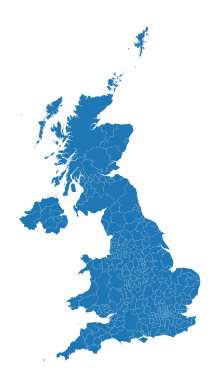

In [24]:
# geopandas will automatically plot the active geography 
ax = gdf_gas.plot()


# # Hide X and Y axes label marks
# ax.xaxis.set_tick_params(labelbottom=False)
# ax.yaxis.set_tick_params(labelleft=False)

# # Hide X and Y axes tick marks
# ax.set_xticks([])
# ax.set_yticks([])

# # or do it all with the tick_params argument 
ax.tick_params(left = False, right = False , bottom = False, 
               labelleft = False ,labelbottom = False)


# and if you want to remove the border 
for spine in plt.gca().spines.values():
    spine.set_visible(False)

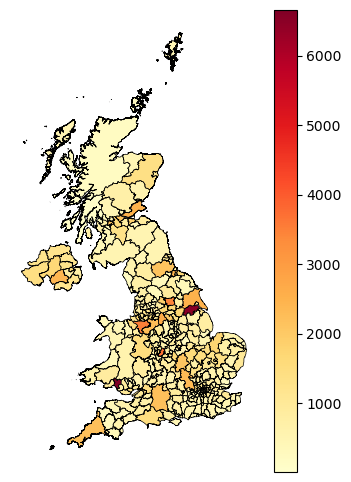

In [25]:
# try out the colour coding 
ax = gdf_gas.plot("CO2", 
                  figsize = (4, 6), 
                  cmap="YlOrRd", 
                  edgecolor="k", 
                  legend = True, 
                  linewidth = 0.5)

ax.tick_params(left = False, right = False , bottom = False, 
               labelleft = False ,labelbottom = False)


# and if you want to remove the border 
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    

## Plotting Greenhouse Gas Emmissions by Local Authority District 

In [26]:
# top_offenders = gdf_gas.sort_values('CO2', ascending = False)[['lad22nm','long', 'lat', 'CO2']].head(1)
# top_offenders = top_offenders.rename({'CO2': 'co2e'}, axis = 1)
# top_offenders['gas'] = 'CO2'

# for gas in ['CH4', 'N2O']: 
#     new_line = gdf_gas.sort_values(gas, ascending = False)[['lad22nm','long', 'lat', gas]].head(1)
#     new_line = new_line.rename({gas: 'co2e'}, axis = 1)
#     new_line['gas'] = gas
#     top_offenders = pd.concat([top_offenders, new_line], axis=0, ignore_index = True)

In [27]:
# # we'll plot these as well as data points, so need to make it a geo dataframe
# # first, set the CRS that defines the current coordinate system (4326) 
# # then, set to the projection that we're using for the rest of the data (27700) 

# top_offenders = geopandas.GeoDataFrame(
#     top_offenders, geometry=geopandas.points_from_xy(top_offenders.long, top_offenders.lat), crs="EPSG:4326"
# )

# top_offenders = top_offenders.to_crs(crs = 27700)

# # confirm that these match 
# print(top_offenders.crs)
# print(gdf_gas.crs)

In [28]:
# top_offenders

In [29]:
# top_offenders[top_offenders.gas == gas]['geometry'].y.iloc[0]

In [30]:
# # create subplots 
# fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 9))
# fig.suptitle("Greenhouse gas emissions (2020) by Local Authority District", fontsize=16, fontweight = "bold")

# # map each ghg to it's own subplot 
# for i, gas in enumerate(['CO2', 'CH4', 'N2O']): 
#     # map the LAD boundaries 
#     gdf_gas.plot(gas, 
#                  cmap="Purples", 
#                  edgecolor="k", 
#                  legend = True, 
#                  legend_kwds={"label": "Kiloton CO2 Equivalent", "location": "bottom", "pad" : 0.1}, 
#                  linewidth = 0.5, 
#                  ax = ax[i]) 
    
#     # overlay the data of the top offenders in each gas category 
#     top_offenders[top_offenders.gas == gas].plot(ax = ax[i], color = 'crimson', markersize = 40)
    
#     text_string = 'LA with highest emmisions:\n{lad} \nCO2 equivalent: {amount} kt'.format(
#         lad = top_offenders[top_offenders.gas == gas].lad22nm.iloc[0], 
#         amount = int(top_offenders[top_offenders.gas == gas].co2e.iloc[0]))
    
#     ax[i].text(
#         top_offenders[top_offenders.gas == gas]['geometry'].x.iloc[0] + 20000, 
#         top_offenders[top_offenders.gas == gas]['geometry'].y.iloc[0] + 20000, 
#         text_string, 
#         color='white', 
#         fontsize = 8,
#         fontweight = 'bold', 
#         bbox=dict(color = 'dimgrey', boxstyle="round"))

    
#     # removing ticks and tick labels 
#     ax[i].tick_params(left = False, right = False , bottom = False, 
#                labelleft = False ,labelbottom = False)
    
#     ax[i].set_title('Greenhouse Gas: {gas}'.format(gas = gas), fontsize = 10)
#     # removing the plot border 
#     ax[i].set(frame_on=False)

In [31]:
# plotting function 

def plot_gas_emissions(df, gas_list, plot_title = "UK Greenhouse Gas Emissions"): 
    """
    Function to map greenhouse gas emissions across the UK. For each gas listed, 
    the Local Authority with the highest emmisions of this gas will be highlighted. 
    
    Parameters:
    -----------
    
        df: GeoDataframe containing the polygon geometries to be mapped. 
            Must have the active geometry set to a 'geometry' column. 
        gas_list: List of greenhouse gasses to plot. Each will be assigned it's own subplot. 
        plot_title: Pass in your own title. Defaults to "UK Greenhouse Gas Emissions" 
        
        
    Returns: 
    ----------
    Matplotlib fig, ax values. 
    
    """
    # DATA PREP 
    # create dataframe containing LA data with highest emmision values 
    
    top_offenders = df.sort_values(gas_list[0], ascending = False)[['lad22nm','long', 'lat', gas_list[0]]].head(1)
    top_offenders = top_offenders.rename({gas_list[0]: 'co2e'}, axis = 1)
    top_offenders['gas'] = gas_list[0]

    if len(gas_list) > 1: 
        for gas in gas_list[1:]: 
            new_line = gdf_gas.sort_values(gas, ascending = False)[['lad22nm','long', 'lat', gas]].head(1)
            new_line = new_line.rename({gas: 'co2e'}, axis = 1)
            new_line['gas'] = gas
            top_offenders = pd.concat([top_offenders, new_line], axis=0, ignore_index = True)
            
    # convert the data to a GeoDataFrame, and set the correct CRS for coordinate points        
    top_offenders = geopandas.GeoDataFrame(
        top_offenders, 
        geometry=geopandas.points_from_xy(top_offenders.long, top_offenders.lat), 
        crs="EPSG:4326"
        )
    # then convert the CRS to match the crs associated with the original dataframe 
    # if we don't do this, the projections of our plots will not align 
    top_offenders = top_offenders.to_crs(crs = gdf_gas.crs)

    # START PLOTTING 
    n_plots = len(gas_list)
    
    fig, ax = plt.subplots(nrows = 1, ncols = n_plots, figsize = (n_plots*4, 9))
    fig.suptitle(plot_title, fontsize=16, fontweight = "bold")

    # map each ghg to it's own subplot 
    for i, gas in enumerate(gas_list): 
        # map the LAD boundaries 
        df.plot(gas, 
             cmap="Purples", 
             edgecolor="k", 
             legend = True, 
             legend_kwds={"label": "Kiloton CO2 Equivalent", "location": "bottom", "pad" : 0.1}, 
             linewidth = 0.5, 
             ax = ax[i]) 

        # overlay the data of the top offenders in each gas category 
        top_offenders[top_offenders.gas == gas].plot(ax = ax[i], color = 'crimson', markersize = 40)

        text_string = 'LA with highest emmisions:\n{lad} \nCO2 equivalent: {amount} kt'.format(
            lad = top_offenders[top_offenders.gas == gas].lad22nm.iloc[0], 
            amount = int(top_offenders[top_offenders.gas == gas].co2e.iloc[0]))

        ax[i].text(
            top_offenders[top_offenders.gas == gas]['geometry'].x.iloc[0] + 20000, 
            top_offenders[top_offenders.gas == gas]['geometry'].y.iloc[0] + 20000, 
            text_string, 
            color='white', 
            fontsize = 8,
            fontweight = 'bold', 
            bbox=dict(color = 'dimgrey', boxstyle="round"))


        # removing ticks and tick labels 
        ax[i].tick_params(left = False, right = False , bottom = False, 
                   labelleft = False ,labelbottom = False)

        ax[i].set_title('Greenhouse Gas: {gas}'.format(gas = gas), fontsize = 10)
        # removing the plot border 
        ax[i].set(frame_on=False)
        
    return fig, ax

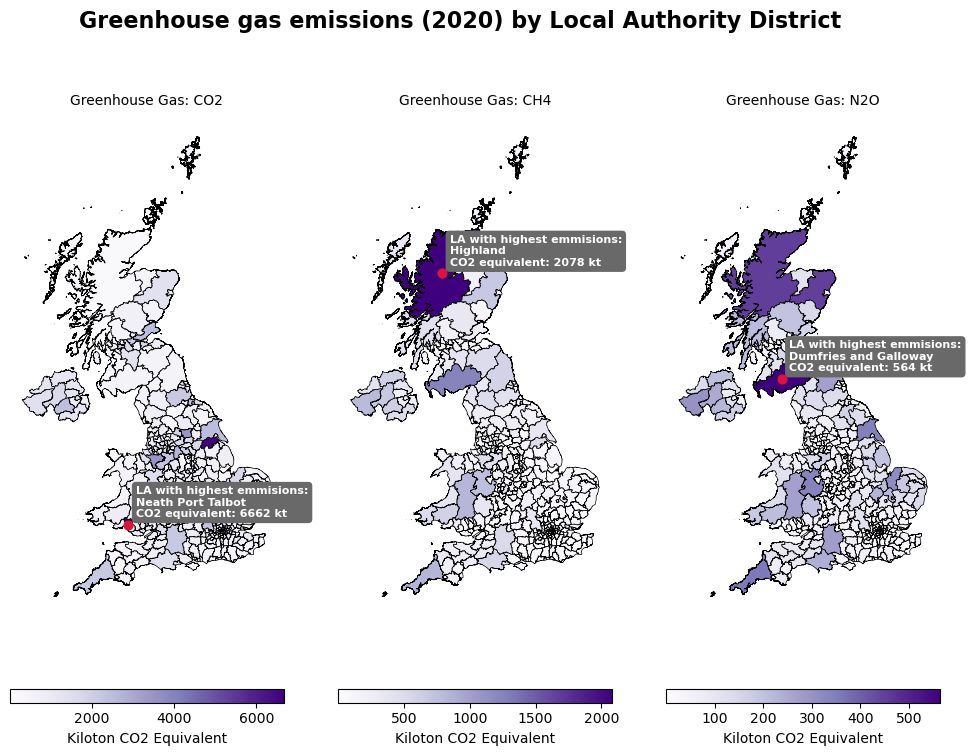

In [37]:
df = gdf_gas
gas_list = ['CO2', 'CH4', 'N2O']
plot_title = "Greenhouse gas emissions (2020) by Local Authority District"

fig, ax = plot_gas_emissions(df, gas_list, plot_title)

In [38]:
fig.savefig('imgs/ghg_example.png', dpi = 200)

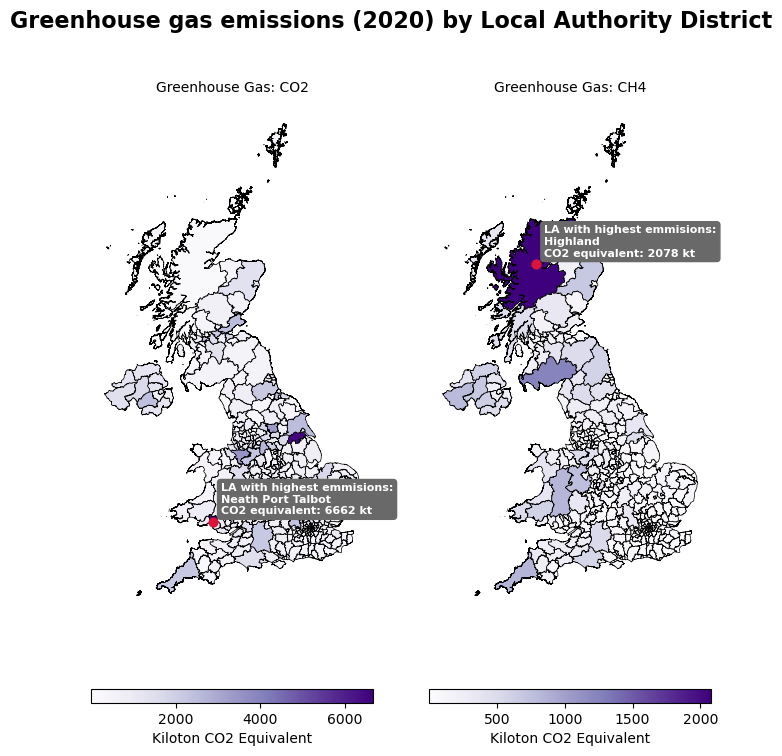

In [33]:
df = gdf_gas
gas_list = ['CO2', 'CH4']
plot_title = "Greenhouse gas emissions (2020) by Local Authority District"

fig, ax = plot_gas_emissions(df, gas_list, plot_title)

In [34]:
# Future ideas: 
# -- plot a population adjusted view. 